In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
from getpass import getpass
GOOGLE_API_KEY = getpass("Enter your Google API Key: ")

In [21]:
import os
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [22]:
from typing import TypedDict, Optional, List
from langchain_core.messages import BaseMessage
# from langchain_core.agents import AgentFinish, AgentAction
from playwright.async_api import Page

class BBox(TypedDict):
    x:float
    y:float
    text: str
    type: str
    ariaLabel: str
    
class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]

class AgentState(TypedDict):
    page: Page
    input: str
    img: str
    bboxes: List[BBox]
    prediction: Prediction
    scratchpad: list[BaseMessage]
    observation: str

In [23]:
from langgraph.types import interrupt
import asyncio
import platform

async def click(state: AgentState):
    page =  state["page"]
    click_args = state["prediction"]['args']
    if click_args is None or len(click_args)!=1:
        return f"Failed to click. Checkpoint 1"
    bbox_id = int(click_args[0])   
    try:
        bbox = state['bboxes'][bbox_id]
    except:
        return f"No bbox found for {bbox_id}. Checkpoint 2"
    
    x, y = bbox['x'], bbox['y']
    print(x, y)
    await page.mouse.click(x, y)
    
    return f"Clicked {bbox_id}"

async def type(state: AgentState):
    page =  state["page"]
    type_args = state["prediction"]['args']
    if type_args is None or len(type_args)!=2:
        return f"Failed to Type. Checkpoint 1"
    
    bbox_id = int(type_args[0])   
    print(state)
    try:
        bbox = state['bboxes'][bbox_id]
    except:
        return f"No bbox found for {bbox_id}. Checkpoint 2"

    x, y = bbox['x'], bbox['y']
    text = type_args[1]
    
    await page.mouse.click(x, y)
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text)
    await page.keyboard.press("Enter")
    return f"Typed '{text}' and submitted"


async def scroll(state: AgentState):
    page =  state["page"]
    scroll_args = state["prediction"]['args']
    if scroll_args is None or len(scroll_args)!=2:
        return f"Failed to scroll. Checkpoint 1"
    
    target, direction = scroll_args
    if target.upper() == "WINDOW":
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"

async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."

async def user_solve_captcha(state: AgentState):
    value = interrupt("User is needed to solve the CAPTCHA!")
    if value['status'] == "SOLVED":
        return f"User solved the CAPTCHA."
    else: 
        return f"User failed to solve CAPTCHA because {value['message']}"


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

async def talk_to_human(state: AgentState):
    pass

In [24]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [30]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}

def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}

prompt = hub.pull("wfh/web-voyager")

/var/home/oliver/Documents/MyCode/browser-use/vbrowser/lib64/python3.13/site-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [3]:
with open("agent_prompt.txt") as f:
    prompt.messages[0].prompt[0].template = f.read()

/bin/bash: line 1: langchainhub: command not found


In [32]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "WebVoyager"  # Optional, groups runs

prompt

ChatPromptTemplate(input_variables=['bbox_descriptions', 'img', 'input'], optional_variables=['scratchpad'], input_types={'scratchpad': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(t

In [39]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableLambda
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", convert_system_message_to_human=True, google_api_key=GOOGLE_API_KEY,temperature=0.7, top_p=0.9)

agent = annotate | (
    format_descriptions
    | prompt
    | llm
    | StrOutputParser()
    | parse
    | RunnableLambda(lambda x: {"prediction": x})
)

In [40]:
# from langchain_core.runnables import RunnableLambda

# def log_stage(name):
#     return RunnableLambda(lambda x: (print(f"\n🔍 {name}:\n{x}"), x)[1])

# llm_chain = (
#     format_descriptions
#     | log_stage("After format_descriptions")
#     | prompt
#     | log_stage("After prompt")
#     | llm
#     | log_stage("After llm")
#     | StrOutputParser()
#     | log_stage("After parsing")
#     | parse
#     | log_stage("After final parse")
#     | RunnableLambda(lambda x: {"prediction": x})
# )
# agent = (
#     annotate
#     | llm_chain
#     | RunnableLambda(lambda x: print("🔍 Final output:", x) or x)

# ).with_config(verbose=True)


from langchain_core.runnables import RunnablePassthrough, RunnableLambda

def log_stage(name):
    return RunnableLambda(lambda x: (print(f"\n🔍 {name}:\n{x}"), x)[1])

agent = (
    annotate
    | RunnablePassthrough.assign(
        # Everything in this sub-chain will run on the same dictionary from 'annotate',
        # and the final result is stored under the 'prediction' key. 
        prediction=(
            format_descriptions
            # | log_stage("After format_descriptions")
            | prompt
            # | log_stage("After prompt")
            | llm
            # | log_stage("After llm")
            | StrOutputParser()
            # | log_stage("After parsing")
            | parse
            # | log_stage("After final parse")
        )
    )
    # After 'assign', we still have *all* original fields (like "bbox") plus "prediction".
    # | RunnableLambda(lambda x: print("🔍 Final output:", x) or x)
).with_config(verbose=True)


In [41]:
import re
from langchain_core.messages import SystemMessage

def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [42]:
from langgraph.graph import END, START, StateGraph
from langchain_core.runnables import RunnableLambda
from langgraph.checkpoint.memory import InMemorySaver

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.add_edge(START, "agent")


graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type,
    "Scroll": scroll,
    "Wait": wait,
    "Captcha": user_solve_captcha,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        log_stage(f"Now tool Calling..{node_name}") | RunnableLambda(tool) | log_stage("After tool Calling") | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(states: AgentState):
    print("I am here.")
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    print(states)
    action = states["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

saver = InMemorySaver()  
graph = graph_builder.compile(checkpointer=saver)

In [56]:
from IPython.display import clear_output, display
from playwright.async_api import async_playwright
# from langchain.types import Command

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, thread_id: int, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
            "configurable": {"thread_id": thread_id},
        },
    )

    final_answer = None
    steps = []

    async for event in event_stream:
        if "agent" not in event:
            continue

        data = event["agent"]

        # Handle interruption (e.g., CAPTCHA)
        if data.get("__type__") == "interrupt":
            clear_output(wait=False)
            print(data)
            print(f"🛑 INTERRUPT: {data.get('message', 'Human input required')}")
            if "screenshot" in data:
                display(Image(base64.b64decode(data["screenshot"])))

            input("👉 Press Enter after completing the required action (e.g. solving CAPTCHA)...")

            # Resume the graph
            await graph.ainvoke(
                Command(resume="User manually completed the task ✅"),
                config={"configurable": {"thread_id": thread_id}},
            )
            continue

        # Handle normal agent step
        pred = data.get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))

        if "img" in data:
            display(Image(base64.b64decode(data["img"])))

        if action and "ANSWER" in action:
            final_answer = action_input[0] if isinstance(action_input, list) else action_input
            break

    return final_answer

TimeoutError: Page.goto: Timeout 30000ms exceeded.
Call log:
  - navigating to "https://www.google.com/", waiting until "load"


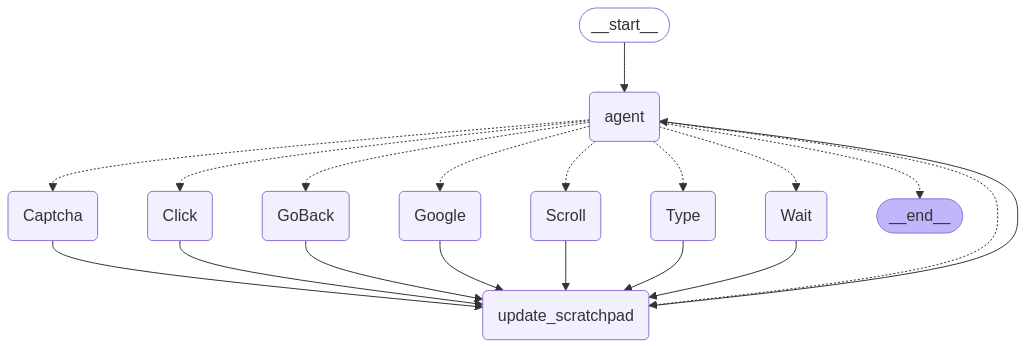

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [45]:
await graph.ainvoke({
            "page": page,
            "input": "Could you explain the WebVoyager paper (on arxiv)?",
            "scratchpad": [],
        },
        {
            "recursion_limit": 50,
        })

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']

In [26]:
res = await call_agent("Write a letter in Google Docs to my Papa, thanking him for everything, and save the document as a PDF", page, 1)
print(f"Final response: {res}")

NameError: name 'call_agent' is not defined

In [ ]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "WebVoyager"  # Optional, groups runs
